In [3]:
# Function estimation using neural network, libraries

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from numpy import asarray
from matplotlib import pyplot as plt
import math as m
import random as r
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix

In [4]:
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_path = '/content/drive/MyDrive/cs4243/CS4243 Project/data/image_data_cleaned'
test_path = '/content/drive/MyDrive/cs4243/CS4243 Project/data/test_image_data_cleaned'

In [6]:
image_size = (256,256)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3363 files belonging to 2 classes.
Using 2691 files for training.
Found 3363 files belonging to 2 classes.
Using 672 files for validation.
Found 1931 files belonging to 2 classes.


In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.2),  # Randomly zoom into images
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),  # Randomly translate images
        layers.experimental.preprocessing.RandomContrast(0.2),  # Randomly adjust contrast
    ]
)

In [8]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)

    # Convolutional Block 1
    x = layers.Conv2D(32, 3, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.01), kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)


    # Convolutional Block 2
    # x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    # x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.01), kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.BatchNormalization()(x)


    x = layers.GlobalAveragePooling2D()(x)

    # x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, kernel_regularizer=keras.regularizers.l2(0.01))(x)
    # x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Adding dropout for regularization
    x = layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.01))(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)

    return model

In [69]:
model = make_model(input_shape=image_size + (3,) )

In [70]:
optimizer = tf.keras.optimizers.Adam(0.001)
optimizer.learning_rate.assign(0.0001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [71]:
epochs = 25

In [72]:
from keras.callbacks import LearningRateScheduler

def schedule(epoch, lr):
    if epoch < 12:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (12 - epoch))

# Create an instance of the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(schedule)

In [73]:
# compiling and training our model
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [74]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      1849

In [75]:
history = model.fit(
    train_ds, epochs=epochs,
    validation_data=val_ds,
    callbacks=[lr_scheduler]

)

Epoch 1/25
169/169 [==============================] - 85s 464ms/step - loss: 2.8138 - accuracy: 0.6336 - val_loss: 2.6850 - val_accuracy: 0.5685 - lr: 1.0000e-04
Epoch 2/25
169/169 [==============================] - 82s 469ms/step - loss: 2.4591 - accuracy: 0.6838 - val_loss: 2.3784 - val_accuracy: 0.6265 - lr: 1.0000e-04
Epoch 3/25
169/169 [==============================] - 86s 489ms/step - loss: 2.1806 - accuracy: 0.6904 - val_loss: 2.1167 - val_accuracy: 0.6741 - lr: 1.0000e-04
Epoch 4/25
169/169 [==============================] - 86s 495ms/step - loss: 1.9450 - accuracy: 0.7176 - val_loss: 1.8601 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 5/25
169/169 [==============================] - 84s 479ms/step - loss: 1.7520 - accuracy: 0.7258 - val_loss: 1.6519 - val_accuracy: 0.7307 - lr: 1.0000e-04
Epoch 6/25
169/169 [==============================] - 81s 463ms/step - loss: 1.5838 - accuracy: 0.7406 - val_loss: 1.5142 - val_accuracy: 0.7396 - lr: 1.0000e-04
Epoch 7/25
169/169 [========

In [42]:
model.save('/content/drive/MyDrive/cs4243/CS4243 Project/models/seannet_lrdecay00001_25_2block_2xL2_2xconvL2_leakyRelu.h5')

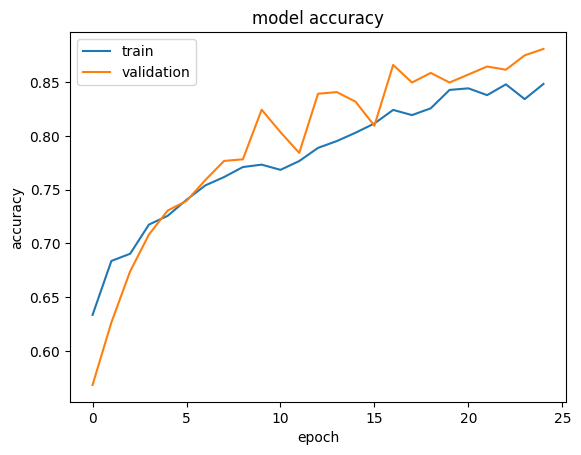

In [76]:
# Accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

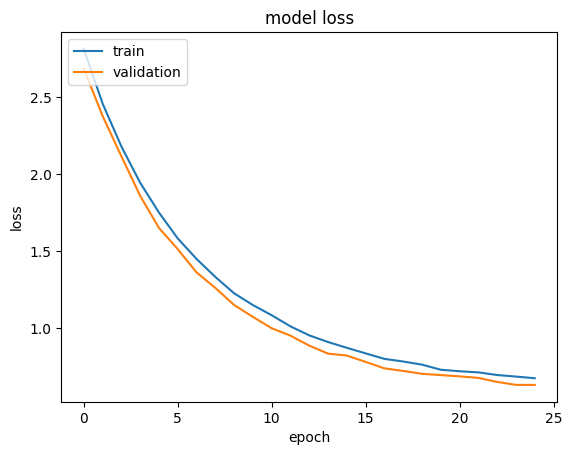

In [77]:
# Loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [78]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the evaluation results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



121/121 [==============================] - 33s 260ms/step - loss: 1.1173 - accuracy: 0.6033
Test Loss: 1.1172577142715454
Test Accuracy: 0.6033143401145935


In [20]:
predictions = model.predict(test_ds)
true_labels = np.concatenate([labels for _, labels in test_ds], axis=0)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)
# print(predicted_labels.ravel()[:10])
# print(true_labels[:10])

cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

TN, FP, FN, TP = confusion_matrix(true_labels, predicted_labels).ravel()
print(f"TN:{TN}")
print(f"FP:{FP}")
print(f"FN:{FN}")
print(f"TP:{TP}")

 26/121 [=====>........................] - ETA: 35s

KeyboardInterrupt: ignored